In [25]:
from keras.layers import Dense, Conv2D,MaxPooling2D,Conv1D,MaxPooling1D,Input,Activation,Flatten, Dropout,UpSampling2D
from keras.models import Sequential
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


### Code to generate data set ( proposed by the professor)

In [45]:

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


# im = generate_a_rectangle(10, True)
# plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

# im = generate_a_disk(10)
# plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

# [im, v] = generate_a_triangle(20, False)
# plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i,end='\r')
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i,end="\r")
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

# 3. Simple Classification 
## 3.1. Generation of simple classification data set 

In [3]:
# generate classification
[X_train, Y_train] = generate_dataset_classification(600,0.0,False)
Y_train = to_categorical(Y_train)
print(len(X_train),len(Y_train))
print(X_train[0],Y_train[0])

Creating data:
600 600
[1. 1. 1. ... 1. 1. 1.] [0. 1. 0.]


### 3.2. Create and fit a simple model with SGD optimizer

NB : please modify the random seed value if you see that the loss does not decrease

In [4]:
simple_model_sgd = Sequential()
simple_model_sgd.add(Dense(3, activation="sigmoid"))
simple_model_sgd.add(Activation("softmax"))
simple_model_sgd.compile(optimizer="sgd",loss="categorical_crossentropy", metrics =["accuracy"])
simple_model_sgd.fit(x=X_train,y=Y_train,batch_size=32,epochs=40,validation_split=0.1)

Train on 540 samples, validate on 60 samples
Epoch 1/40
540/540 [==============================] - 1s 2ms/step - loss: 1.0519 - acc: 0.4296 - val_loss: 0.9904 - val_acc: 0.6833
Epoch 2/40
540/540 [==============================] - 0s 114us/step - loss: 0.9695 - acc: 0.6315 - val_loss: 0.9128 - val_acc: 0.6833
Epoch 3/40
540/540 [==============================] - 0s 122us/step - loss: 0.9080 - acc: 0.7000 - val_loss: 0.8815 - val_acc: 0.7333
Epoch 4/40
540/540 [==============================] - 0s 121us/step - loss: 0.8743 - acc: 0.7389 - val_loss: 0.8502 - val_acc: 0.7167
Epoch 5/40
540/540 [==============================] - 0s 124us/step - loss: 0.8496 - acc: 0.7481 - val_loss: 0.8736 - val_acc: 0.7500
Epoch 6/40
540/540 [==============================] - 0s 116us/step - loss: 0.8328 - acc: 0.7574 - val_loss: 0.8217 - val_acc: 0.7833
Epoch 7/40
540/540 [==============================] - 0s 124us/step - loss: 0.8131 - acc: 0.7815 - val_loss: 0.8037 - val_acc: 0.8500
Epoch 8/40
540/540 

### 3.2. Create and fit a simple model with ADAM optimizer

NB : please modify the random seed value if you see that the loss does not decrease

In [7]:
np.random.seed(50)
simple_model_adam = Sequential()
simple_model_adam.add(Dense(3, activation="sigmoid"))
simple_model_adam.add(Activation("softmax"))
simple_model_adam.compile(optimizer="adam",loss="categorical_crossentropy", metrics = ["accuracy"])
simple_model_adam_history = simple_model_adam.fit(x=X_train,y=Y_train,batch_size=32,epochs=30,validation_split = 0.1)

Train on 540 samples, validate on 60 samples
Epoch 1/30
540/540 [==============================] - 0s 542us/step - loss: 0.9639 - acc: 0.5944 - val_loss: 0.8147 - val_acc: 0.7167
Epoch 2/30
540/540 [==============================] - 0s 137us/step - loss: 0.7848 - acc: 0.7593 - val_loss: 0.7402 - val_acc: 0.7833
Epoch 3/30
540/540 [==============================] - 0s 135us/step - loss: 0.7265 - acc: 0.8463 - val_loss: 0.6961 - val_acc: 0.8667
Epoch 4/30
540/540 [==============================] - 0s 132us/step - loss: 0.7028 - acc: 0.8944 - val_loss: 0.6708 - val_acc: 1.0000
Epoch 5/30
540/540 [==============================] - 0s 134us/step - loss: 0.6727 - acc: 0.9537 - val_loss: 0.6431 - val_acc: 1.0000
Epoch 6/30
540/540 [==============================] - 0s 137us/step - loss: 0.6440 - acc: 0.9833 - val_loss: 0.6361 - val_acc: 0.9500
Epoch 7/30
540/540 [==============================] - 0s 132us/step - loss: 0.6453 - acc: 0.9537 - val_loss: 0.6231 - val_acc: 0.9833
Epoch 8/30
540/54

Plot the history of accuray values

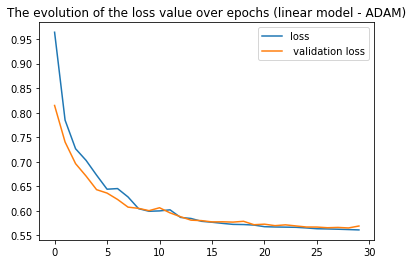

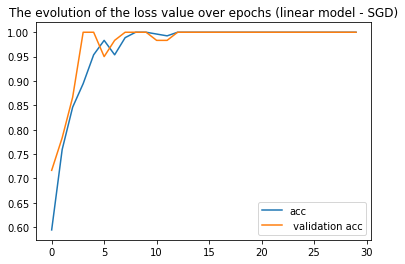

In [8]:
plt.figure()
plt.plot(simple_model_adam_history.history["loss"],label ="loss")
plt.plot(simple_model_adam_history.history["val_loss"],label =" validation loss")
plt.legend()
plt.title("The evolution of the loss value over epochs (linear model - ADAM)")

plt.figure()
plt.plot(simple_model_adam_history.history["acc"],label ="acc")
plt.plot(simple_model_adam_history.history["val_acc"],label =" validation acc")
plt.title("The evolution of the loss value over epochs (linear model - SGD)")
plt.legend()

## Test the model

In [9]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
simple_model_adam.predict(X_test)

array([[0.21194157, 0.5761169 , 0.21194157]], dtype=float32)

# 4. Visualisation of the solution

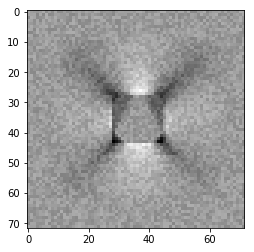

In [10]:
w1 = simple_model_adam.get_weights()[0][:,0].reshape((72,72))
plt.imshow(w1, cmap="gray")

It has a rectangle form

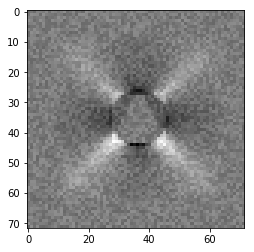

In [11]:
w2 = simple_model_adam.get_weights()[0][:,1].reshape((72,72))
plt.imshow(w2, cmap="gray")

It has a disk form

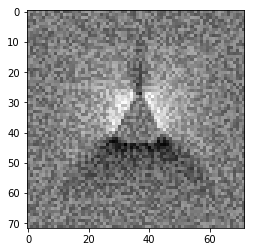

In [12]:
w3 = simple_model_adam.get_weights()[0][:,2].reshape((72,72))
plt.imshow(w3, cmap="gray")

It has a triangle form

# 5. A More Difficult Classification Problem
### 5.1. Data Generation

In [13]:
nb_samples = 1000
[X_train_not_centred, Y_train_not_centred] = generate_dataset_classification(nb_samples,noise=0.0, free_location=True)
Y_train_not_centred = to_categorical(Y_train_not_centred)
X_train_not_centred = X_train_not_centred.reshape(nb_samples,72,72)

Creating data:


In [14]:
X_train_not_centred = X_train_not_centred.reshape(nb_samples,72,72,1)

### 5.2. Builiding and training the model

In [129]:
np.random.seed(64)
model_not_centred_noise = Sequential()
model_not_centred_noise.add(Conv2D(16,kernel_size=(5,5),padding="same",input_shape=(72,72,1)))
model_not_centred_noise.add(MaxPooling2D(pool_size=(2,2)))
model_not_centred_noise.add(Flatten())
model_not_centred_noise.add(Dense(3, activation="sigmoid"))
model_not_centred_noise.add(Activation("softmax"))

model_not_centred_noise.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])
history_model_not_centred_noise = model_not_centred_noise.fit(X_train_not_centred,Y_train_not_centred,batch_size=32,epochs=50,validation_split=0.1)

Train on 900 samples, validate on 100 samples
Epoch 1/50
900/900 [==============================] - 2s 2ms/step - loss: 1.1346 - acc: 0.3767 - val_loss: 1.0472 - val_acc: 0.3800
Epoch 2/50
900/900 [==============================] - 0s 294us/step - loss: 1.0182 - acc: 0.3922 - val_loss: 0.9636 - val_acc: 0.5300
Epoch 3/50
900/900 [==============================] - 0s 300us/step - loss: 0.9171 - acc: 0.6578 - val_loss: 0.8916 - val_acc: 0.6900
Epoch 4/50
900/900 [==============================] - 0s 295us/step - loss: 0.8733 - acc: 0.6889 - val_loss: 0.8827 - val_acc: 0.6000
Epoch 5/50
900/900 [==============================] - 0s 298us/step - loss: 0.8404 - acc: 0.7222 - val_loss: 0.8335 - val_acc: 0.7500
Epoch 6/50
900/900 [==============================] - 0s 304us/step - loss: 0.8133 - acc: 0.7700 - val_loss: 0.8179 - val_acc: 0.7700
Epoch 7/50
900/900 [==============================] - 0s 296us/step - loss: 0.7871 - acc: 0.8122 - val_loss: 0.8078 - val_acc: 0.7700
Epoch 8/50
900/900

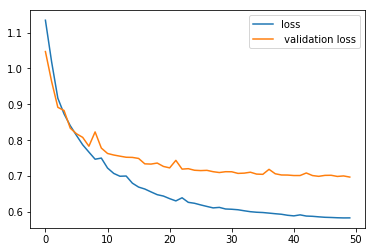

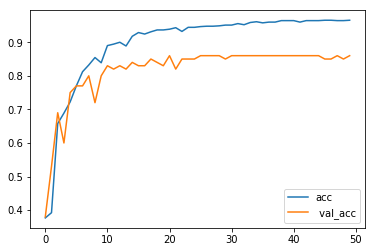

In [16]:
plt.figure()
plt.plot(history_model_not_centred_noise.history["loss"],label ="loss")
plt.plot(history_model_not_centred_noise.history["val_loss"],label =" validation loss")
plt.legend()

plt.figure()
plt.plot(history_model_not_centred_noise.history["acc"],label ="acc")
plt.plot(history_model_not_centred_noise.history["val_acc"],label =" val_acc")
plt.legend()

In [143]:
np.random.seed(51)
model_not_centred_noise_1 = Sequential()
model_not_centred_noise_1.add(Conv2D(32,kernel_size=(5,5),strides=1,input_shape=(72,72,1)))
model_not_centred_noise_1.add(MaxPooling2D(pool_size=(2,2)))
model_not_centred_noise_1.add(Conv2D(16,kernel_size=(5,5),strides=1,input_shape=(72,72,1)))
model_not_centred_noise_1.add(MaxPooling2D(pool_size=(2,2)))
model_not_centred_noise_1.add(Flatten())
model_not_centred_noise_1.add(Dense(3, activation="sigmoid"))
model_not_centred_noise_1.add(Activation("softmax"))

model_not_centred_noise_1.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])
model_not_centred_noise_1_history = model_not_centred_noise_1.fit(X_train_not_centred,Y_train_not_centred,batch_size=32,epochs=10,validation_split=0.1)

Train on 900 samples, validate on 100 samples
Epoch 1/10
900/900 [==============================] - 2s 3ms/step - loss: 1.0806 - acc: 0.3744 - val_loss: 1.0219 - val_acc: 0.4700
Epoch 2/10
900/900 [==============================] - 0s 451us/step - loss: 0.9900 - acc: 0.5356 - val_loss: 0.9185 - val_acc: 0.6000
Epoch 3/10
900/900 [==============================] - 0s 435us/step - loss: 0.8965 - acc: 0.6400 - val_loss: 0.8547 - val_acc: 0.6900
Epoch 4/10
900/900 [==============================] - 0s 424us/step - loss: 0.8598 - acc: 0.6622 - val_loss: 0.8160 - val_acc: 0.7200
Epoch 5/10
900/900 [==============================] - 0s 423us/step - loss: 0.8228 - acc: 0.7178 - val_loss: 0.8050 - val_acc: 0.7300
Epoch 6/10
900/900 [==============================] - 0s 418us/step - loss: 0.8095 - acc: 0.7244 - val_loss: 0.7857 - val_acc: 0.7700
Epoch 7/10
900/900 [==============================] - 0s 414us/step - loss: 0.7747 - acc: 0.7711 - val_loss: 0.7598 - val_acc: 0.8200
Epoch 8/10
900/900

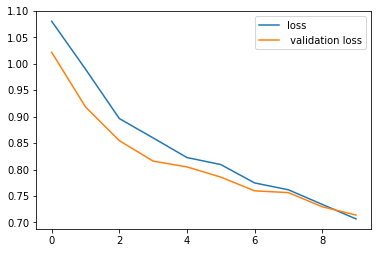

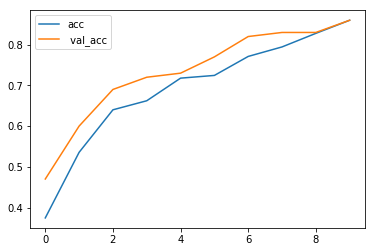

In [144]:
plt.figure()
plt.plot(model_not_centred_noise_1_history.history["loss"],label ="loss")
plt.plot(model_not_centred_noise_1_history.history["val_loss"],label =" validation loss")
plt.legend()

plt.figure()
plt.plot(model_not_centred_noise_1_history.history["acc"],label ="acc")
plt.plot(model_not_centred_noise_1_history.history["val_acc"],label =" val_acc")
plt.legend()

In [145]:
[X_test, Y_test] = generate_dataset_classification(300, noise=0.0, free_location=True)
Y_test = to_categorical(Y_test)
X_test = X_test.reshape(X_test.shape[0],72,72,1)
ev = model_not_centred_noise_1.evaluate(X_test,Y_test)
print(model_not_centred_noise_1.metrics_names[0]," = ",ev[0])
print(model_not_centred_noise_1.metrics_names[1]," = ",ev[1])

Creating data:
300/300 [==============================] - 0s 189us/step
loss  =  0.745461331208547
acc  =  0.8066666666666666


# 6. A regression problem

## 6.1. Data set creation

In [20]:
[X_train_reg, Y_train_reg] = generate_dataset_regression(10000)

Creating data:


### Normalization
To normalize the target, we sort by the x values

In [21]:
def sort_list_x(positions):
    c = positions.copy().reshape(3,2).argsort(axis=0)[:,0]
    liste = [[positions[2*c[i]]] + [positions[2*c[i]+1]] for i in range(3)]
    liste = np.array(liste).reshape(6)
    return (liste)
def sort_y_by_x(Y_train_reg):
    a = Y_train_reg.copy()
    Y_train_modif = []
    for el in a :
        Y_train_modif.append(sort_list_x(el))
    Y_train_modif = np.array(Y_train_modif)
    return Y_train_modif

Y_train_modif = sort_y_by_x(Y_train_reg)

### create and train the model

In [ ]:


X_train_reg = X_train_reg.reshape(X_train_reg.shape[0],72,72,1)
model_CNN_regr_one_coord = Sequential()

model_CNN_regr_one_coord.add(Conv2D(32, kernel_size = (3,3),  input_shape = (72,72,1)))
# model_CNN_regr_one_coord.add(MaxPooling2D(pool_size=(3, 3)))

model_CNN_regr_one_coord.add(Conv2D(64, kernel_size = (4,4)))
model_CNN_regr_one_coord.add(MaxPooling2D(pool_size=(3, 3)))

model_CNN_regr_one_coord.add(Conv2D(64, kernel_size = (3,3)))
# model_CNN_regr_one_coord.add(MaxPooling2D(pool_size=(3, 3)))

model_CNN_regr_one_coord.add(Flatten())

model_CNN_regr_one_coord.add(Dense(128, activation='relu'))
model_CNN_regr_one_coord.add( Dropout(0.2))
model_CNN_regr_one_coord.add(Dense(6, activation='sigmoid'))


model_CNN_regr_one_coord.compile(optimizer='adam', loss= 'mean_squared_error', metrics=['mse'])
model_CNN_regr_one_coord.summary()

model_CNN_regr_one_coord_history = model_CNN_regr_one_coord.fit(1-X_train_reg[:9000], Y_train_modif[:9000], epochs=10, batch_size = 32, validation_split = 0.1)

Creating data:
[[0.05450021 0.15637994 0.16230495 0.74330693 0.50092006 0.944451  ]]


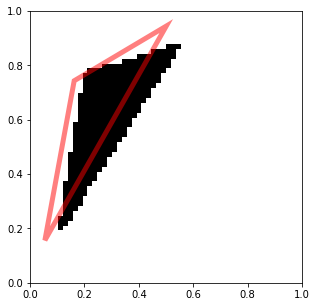

[[0.32660955 0.37064788 0.7215386  0.06578282 0.9354287  0.10627954]]


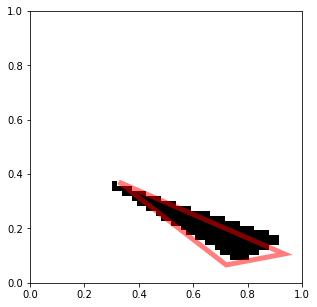

[[0.49980482 0.30198592 0.5818699  0.33684626 0.71228343 0.72671765]]


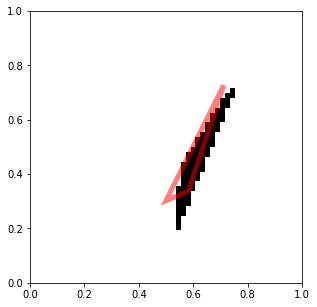

[[0.26444578 0.310599   0.6001953  0.54518396 0.6900401  0.15308706]]


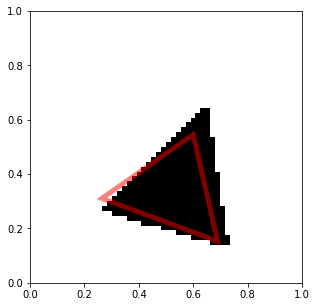

[[0.00436121 0.32128814 0.02635298 0.7475951  0.1055257  0.82618093]]


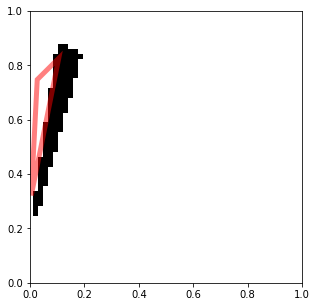

[[0.01662457 0.05038686 0.23361939 0.53084946 0.494898   0.10261358]]


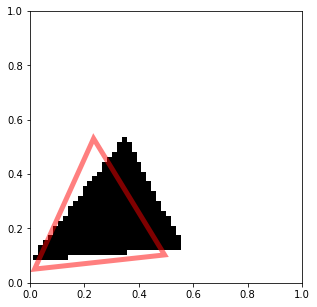

[[0.02044031 0.5835407  0.25474986 0.8694468  0.5340896  0.96244776]]


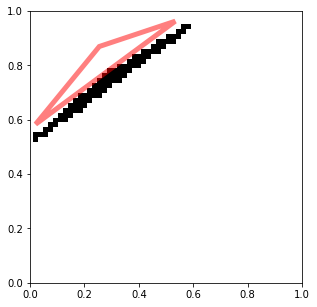

[[0.07846683 0.7883962  0.61619693 0.3624138  0.6623725  0.58201814]]


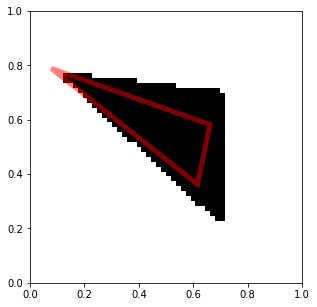

[[0.5865345  0.49634477 0.9046925  0.86416966 0.9833914  0.6441676 ]]


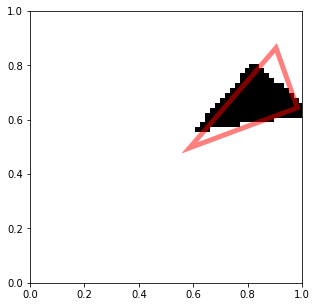

[[0.18255232 0.45959082 0.20851679 0.5598035  0.9255731  0.39694917]]


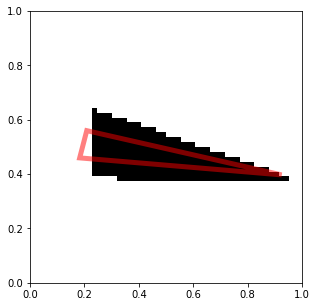

In [23]:
[X_test_reg, Y_test_reg] = generate_dataset_regression(10)
for i in range(len(X_test_reg)):
    x = X_test_reg[i].reshape(1,72,72,1)
    y = model_CNN_regr_one_coord.predict(1-x)
    print(y)
    visualize_prediction(x, y)

# 7. Denoising model
## Noise generation

In [125]:
def generate_a_rectangle_noise(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise),generate_a_drawing(figsize, U, V, 0)
def generate_a_disk_noise(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise),generate_a_drawing(figsize, U, V, 0.0)
def generate_a_triangle_noise(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    imdata2 = generate_a_drawing(figsize,U,V,0.0)
    return imdata,imdata2

def generate_dataset_classification_noise(nb_samples, noise=20, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i,end='\r')
        category = np.random.randint(3)
        category = 0
        if category == 0:
            X[i],Y[i] = generate_a_rectangle_noise(noise, free_location)
            
        elif category == 1: 
            X[i],Y[i] = generate_a_disk_noise(noise, free_location)
        else:
            X[i],Y[i] = generate_a_triangle_noise(noise, free_location)
        
    X = (X + noise) / (255 + 2 * noise)
    Y = Y / 255
    return [X, Y]

In [126]:
[X_noised, X_clean] = generate_dataset_classification_noise(1000,noise=20)
[X_noised_test, X_clean_test] = generate_dataset_classification_noise(100,noise=20)
X_noised, X_clean = X_noised.reshape(X_noised.shape[0],72,72,1),X_clean.reshape(X_clean.shape[0],72,72,1)
X_noised_test, X_clean_test = X_noised_test.reshape(X_noised_test.shape[0],72,72,1),X_clean_test.reshape(X_clean_test.shape[0],72,72,1)

Creating data:
Creating data:


## hour glass model 

In [127]:
hour_glass = Sequential()

hour_glass.add(Conv2D(64, kernel_size = (3, 3), activation='relu', padding='same',  input_shape = (72,72,1)))
hour_glass.add(Conv2D(32, kernel_size = (3, 3), activation='relu',padding='same'))
hour_glass.add(MaxPooling2D(pool_size= (2, 2)))

hour_glass.add(Conv2D(16, kernel_size = (3, 3),activation='relu' , padding='same'))
# auto_encodeur.add(Conv2D(264, kernel_size = (6,6)))
# auto_encodeur.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# auto_encodeur.add(UpSampling2D(size = (2,2)))
# auto_encodeur.add(Conv2D(264, kernel_size = (6,6)))
hour_glass.add(Conv2D(16, kernel_size = (3, 3),activation='relu', padding='same'))

hour_glass.add(UpSampling2D(size = (2, 2)))
hour_glass.add(Conv2D(32, kernel_size = (3, 3),activation='relu', padding='same'))
hour_glass.add(Conv2D(64, kernel_size = (3, 3), activation='relu',padding='same'))


hour_glass.add(Conv2D(1, kernel_size = (3, 3),activation='relu', padding='same'))
hour_glass.add(Conv2D(1, kernel_size = (3, 3),activation='relu', padding='same'))
hour_glass.compile(optimizer='adam', loss= 'mean_squared_error', metrics=['mse'])
hour_glass.summary()

h = hour_glass.fit(X_noised, X_clean, epochs= 15, batch_size = 32, validation_data = (X_noised_test, X_clean_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_187 (Conv2D)          (None, 72, 72, 64)        640       
_________________________________________________________________
conv2d_188 (Conv2D)          (None, 72, 72, 32)        18464     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_189 (Conv2D)          (None, 36, 36, 16)        4624      
_________________________________________________________________
conv2d_190 (Conv2D)          (None, 36, 36, 16)        2320      
_________________________________________________________________
up_sampling2d_29 (UpSampling (None, 72, 72, 16)        0         
_________________________________________________________________
conv2d_191 (Conv2D)          (None, 72, 72, 32)        4640      
__________

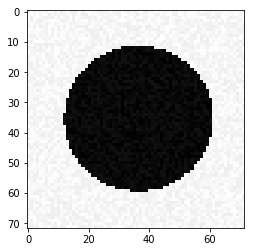

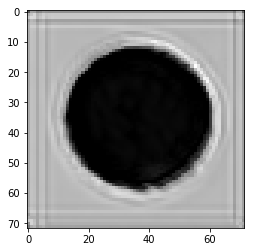

In [122]:
x = generate_a_disk_noise(noise=20)[0]
y = hour_glass.predict(x.reshape(1,72,72,1))
plt.imshow(x.reshape(72,72),cmap = "gray")
plt.figure()
plt.imshow(y[0].reshape(72,72),cmap = "gray")

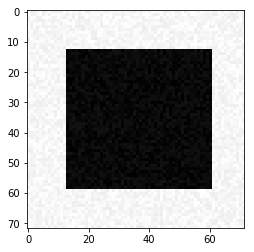

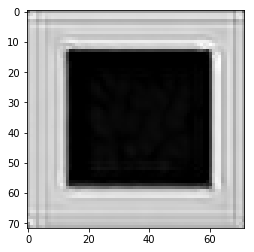

In [123]:
x = generate_a_rectangle_noise(noise=20)[0]
y = hour_glass.predict(x.reshape(1,72,72,1))
plt.imshow(x.reshape(72,72),cmap = "gray")
plt.figure()
plt.imshow(y[0].reshape(72,72),cmap = "gray")

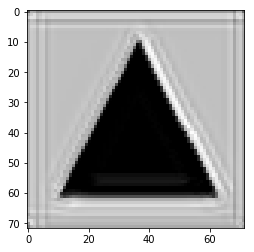

In [124]:
y = hour_glass.predict(generate_a_triangle_noise()[0].reshape(1,72,72,1))
plt.imshow(y[0].reshape(72,72),cmap = "gray")